Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30}
Best Cross-Validation Score: 0.633638814921686

Enhanced Random Forest Model Performance:
MAE: 2.8585667743055523
RMSE: 3.132720674048196
R²: -3.3039326799705044
MAPE: 132.11%
Directional Accuracy: 50.35%
Theil's U: 2.1434


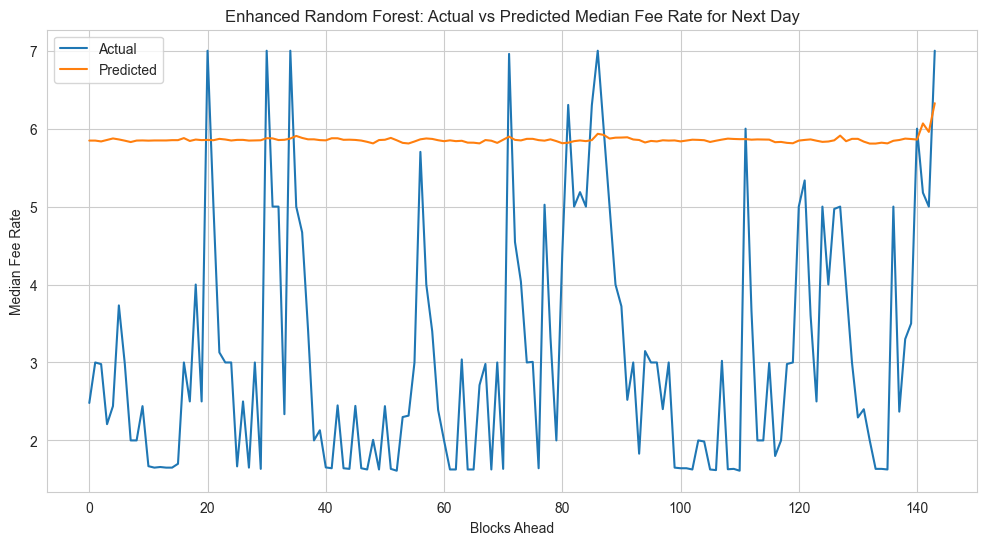

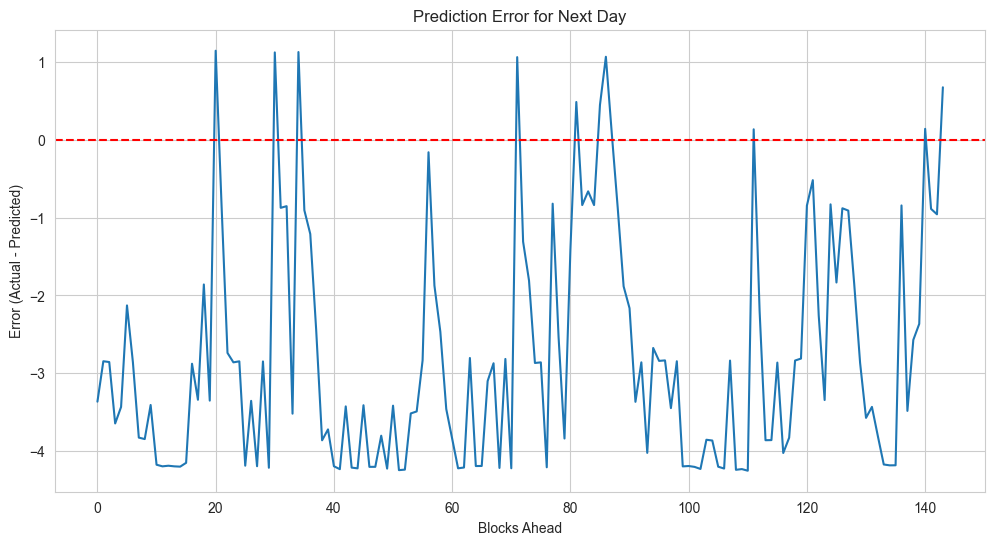


Top 10 Most Important Features:
                        feature  importance
7                 fee_rate_90th    0.406049
17               block_interval    0.208368
43  block_median_fee_rate_lag_1    0.107601
14            transaction_count    0.081273
4                  avg_fee_rate    0.033569
69  block_median_fee_rate_lag_2    0.011739
12                    total_fee    0.009399
23                         hour    0.006142
39      transaction_count_lag_1    0.004877
1                      tx_count    0.004758


In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

def theils_u(y_true, y_pred):
    y_naive = y_true[:-1]  # Naive forecast: use previous value
    numerator = np.sqrt(np.mean((y_true[1:] - y_pred[1:])**2))
    denominator = np.sqrt(np.mean((y_true[1:] - y_naive)**2))
    if denominator == 0:
        return np.inf
    return numerator / denominator


df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])
df = df.sort_values('block_time')


df['hour'] = df['block_time'].dt.hour
df['day_of_week'] = df['block_time'].dt.dayofweek

# Remove problematic columns or convert list-like strings to numeric features
if 'mempool_fee_histogram' in df.columns:
    df.drop('mempool_fee_histogram', axis=1, inplace=True)

# Check and convert any list-like strings in features
for col in df.columns:
    if df[col].dtype == 'object':
        try:
        
            df[col] = df[col].apply(lambda x: np.mean(eval(x)) if isinstance(eval(x), list) else np.nan)
        except:
      
            df.drop(col, axis=1, inplace=True)

# Create lagged features
def create_lagged_features(df, lags=[1, 2, 3]):
    df_lagged = df.copy()
    for lag in lags:
        for col in df.columns:
            if col != 'block_time':
                df_lagged[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df_lagged

df = create_lagged_features(df)

# Prepare features and target variable
features = [col for col in df.columns if col not in ['block_time', 'block_median_fee_rate']]
X = df[features]
y = df['block_median_fee_rate']


X = X.dropna()
y = y.loc[X.index]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train = X_scaled[:-144]  # Train on all but the last 144
y_train = y[:-144]
X_test = X_scaled[-144:]   # Test on the last 144 for next day prediction
y_test = y[-144:]


param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                   n_iter=100, cv=tscv, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best model
best_rf_model = random_search.best_estimator_


print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Perform recursive rolling forecast for the next 144 blocks
forecast_df = X[-144:].copy()
predictions = []

for i in range(144):
    # Use the most recent features to predict
    forecast_input = forecast_df.iloc[i].values.reshape(1, -1)
    pred = best_rf_model.predict(forecast_input)[0]
    predictions.append(pred)

  
    new_row = forecast_df.iloc[i].copy()
    new_row['block_median_fee_rate'] = pred  
    

    new_row = new_row.drop('block_median_fee_rate')
 
    forecast_df = pd.concat([forecast_df, new_row.to_frame().T])


mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"\nEnhanced Random Forest Model Performance:")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

mape = mean_absolute_percentage_error(y_test, predictions)
da = directional_accuracy(y_test, predictions)
u = theils_u(y_test.values, predictions)

print(f"MAPE: {mape:.2f}%")
print(f"Directional Accuracy: {da:.2f}%")
print(f"Theil's U: {u:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Enhanced Random Forest: Actual vs Predicted Median Fee Rate for Next Day')
plt.xlabel('Blocks Ahead')
plt.ylabel('Median Fee Rate')
plt.legend()
plt.show()

# Plot prediction error
error = y_test.values - predictions
plt.figure(figsize=(12, 6))
plt.plot(error)
plt.title('Prediction Error for Next Day')
plt.xlabel('Blocks Ahead')
plt.ylabel('Error (Actual - Predicted)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


feature_importance = pd.DataFrame({'feature': features,
                                   'importance': best_rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))
